# KV Caching in Transformer Models: Implementation Guide

## Overview

This notebook provides a comprehensive guide to understanding and implementing KV (Key-Value) caching in transformer models. KV caching is a crucial optimization technique that significantly speeds up autoregressive text generation by avoiding redundant computations.

### What You'll Learn:
- What KV caching is and why it's important
- How attention mechanisms work in transformers
- Step-by-step implementation of KV caching
- Performance comparisons and memory considerations
- Best practices and common pitfalls

## 1. Introduction to Transformer Attention

Before diving into KV caching, let's understand how attention works in transformer models.

### The Attention Mechanism

In transformer models, the attention mechanism computes:
```
Attention(Q, K, V) = softmax(QK^T / √d_k)V
```

Where:
- **Q** (Query): What we're looking for
- **K** (Key): What we're looking at
- **V** (Value): The actual content we extract

### The Problem with Autoregressive Generation

During text generation, we generate tokens one by one. At each step:
1. We have a sequence of length `n`
2. We generate token `n+1`
3. For the next step, we now have a sequence of length `n+1`
4. We recompute attention for ALL tokens (including the previous `n` tokens)

This is wasteful because the K and V representations for previous tokens don't change!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from typing import Optional, Tuple
import matplotlib.pyplot as plt

## 2. Basic Attention Implementation (Without Caching)

Let's start with a standard attention implementation to understand the baseline.

In [2]:
class BasicAttention(nn.Module):
    """Standard multi-head attention without caching."""
    
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections for Q, K, V
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            mask: Optional attention mask
        Returns:
            Output tensor of shape (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        
        # Generate Q, K, V matrices
        Q = self.w_q(x)  # (batch_size, seq_len, d_model)
        K = self.w_k(x)  # (batch_size, seq_len, d_model)
        V = self.w_v(x)  # (batch_size, seq_len, d_model)
        
        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Compute attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Reshape back and apply output projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )
        
        return self.w_o(attention_output)
    
    def scaled_dot_product_attention(
        self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """Compute scaled dot-product attention."""
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax
        attention_weights = F.softmax(scores, dim=-1)
        
        # Apply attention to values
        return torch.matmul(attention_weights, V)

## 3. Understanding the Inefficiency

Let's visualize what happens during autoregressive generation without caching:

In [3]:
def demonstrate_redundant_computation():
    """Demonstrate the redundant computation problem."""
    
    print("=== Autoregressive Generation Without Caching ===")
    print("\nStep 1: Process tokens [A]")
    print("  Compute: Q₁, K₁, V₁")
    print("  Attention: Q₁ × K₁ᵀ")
    
    print("\nStep 2: Process tokens [A, B]")
    print("  Compute: Q₁, Q₂, K₁, K₂, V₁, V₂  ← K₁, V₁ recomputed!")
    print("  Attention: [Q₁, Q₂] × [K₁, K₂]ᵀ")
    
    print("\nStep 3: Process tokens [A, B, C]")
    print("  Compute: Q₁, Q₂, Q₃, K₁, K₂, K₃, V₁, V₂, V₃  ← K₁, K₂, V₁, V₂ recomputed!")
    print("  Attention: [Q₁, Q₂, Q₃] × [K₁, K₂, K₃]ᵀ")
    
    print("\n💡 Key Insight:")
    print("   K and V for previous tokens don't change, but we recompute them every step!")
    print("   Only Q for the new token and the attention computation actually need to be done.")

demonstrate_redundant_computation()

=== Autoregressive Generation Without Caching ===

Step 1: Process tokens [A]
  Compute: Q₁, K₁, V₁
  Attention: Q₁ × K₁ᵀ

Step 2: Process tokens [A, B]
  Compute: Q₁, Q₂, K₁, K₂, V₁, V₂  ← K₁, V₁ recomputed!
  Attention: [Q₁, Q₂] × [K₁, K₂]ᵀ

Step 3: Process tokens [A, B, C]
  Compute: Q₁, Q₂, Q₃, K₁, K₂, K₃, V₁, V₂, V₃  ← K₁, K₂, V₁, V₂ recomputed!
  Attention: [Q₁, Q₂, Q₃] × [K₁, K₂, K₃]ᵀ

💡 Key Insight:
   K and V for previous tokens don't change, but we recompute them every step!
   Only Q for the new token and the attention computation actually need to be done.


## 4. KV Caching: The Solution

KV caching solves this by:
1. **Storing** the K and V matrices from previous steps
2. **Reusing** them in subsequent steps
3. **Appending** only the new K and V vectors for the new token

### Benefits:
- **Speed**: Avoid recomputing K, V for previous tokens
- **Memory**: Trade memory for computation (store K, V caches)
- **Scalability**: Benefits increase with sequence length

In [4]:
class KVCache:
    """A simple KV cache implementation."""
    
    def __init__(self):
        self.k_cache = None  # Cached key vectors
        self.v_cache = None  # Cached value vectors
        
    def update(self, new_k: torch.Tensor, new_v: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Update the cache with new K and V vectors.
        
        Args:
            new_k: New key vectors (batch_size, n_heads, 1, d_k)
            new_v: New value vectors (batch_size, n_heads, 1, d_k)
            
        Returns:
            Tuple of (updated_k_cache, updated_v_cache)
        """
        if self.k_cache is None:
            # First time: initialize cache
            self.k_cache = new_k
            self.v_cache = new_v
        else:
            # Append new vectors to existing cache
            self.k_cache = torch.cat([self.k_cache, new_k], dim=2)
            self.v_cache = torch.cat([self.v_cache, new_v], dim=2)
            
        return self.k_cache, self.v_cache
    
    def clear(self):
        """Clear the cache."""
        self.k_cache = None
        self.v_cache = None
        
    def get_cache_info(self):
        """Get information about the current cache state."""
        if self.k_cache is None:
            return "Cache is empty"
        
        batch_size, n_heads, seq_len, d_k = self.k_cache.shape
        memory_mb = (self.k_cache.numel() + self.v_cache.numel()) * 4 / (1024 * 1024)  # Assuming float32
        
        return f"Cache contains {seq_len} tokens, Memory: {memory_mb:.2f} MB"

## 5. Attention with KV Caching Implementation

In [5]:
class CachedAttention(nn.Module):
    """Multi-head attention with KV caching support."""
    
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # Linear projections
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
    def forward(
        self, 
        x: torch.Tensor, 
        kv_cache: Optional[KVCache] = None,
        use_cache: bool = False,
        mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, Optional[KVCache]]:
        """
        Forward pass with optional KV caching.
        
        Args:
            x: Input tensor (batch_size, seq_len, d_model)
            kv_cache: Optional KV cache from previous steps
            use_cache: Whether to use/update the cache
            mask: Optional attention mask
            
        Returns:
            Tuple of (output, updated_cache)
        """
        batch_size, seq_len, d_model = x.shape
        
        # Always compute Q for the current input
        Q = self.w_q(x)
        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        if use_cache and kv_cache is not None and kv_cache.k_cache is not None:
            # Using cache: only compute K, V for new tokens
            new_K = self.w_k(x)
            new_V = self.w_v(x)
            
            new_K = new_K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
            new_V = new_V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
            
            # Update cache with new K, V
            K, V = kv_cache.update(new_K, new_V)
            
        else:
            # Not using cache or first time: compute full K, V
            K = self.w_k(x)
            V = self.w_v(x)
            
            K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
            V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
            
            if use_cache:
                if kv_cache is None:
                    kv_cache = KVCache()
                kv_cache.update(K, V)
        
        # Compute attention
        attention_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # Reshape and apply output projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )
        
        output = self.w_o(attention_output)
        
        return output, kv_cache if use_cache else None
    
    def scaled_dot_product_attention(
        self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """Compute scaled dot-product attention."""
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attention_weights, V)

## 6. Practical Example: Simulating Text Generation

Let's simulate the text generation process with and without caching to see the difference.

In [6]:
def simulate_text_generation(max_length: int = 10, d_model: int = 512, n_heads: int = 8):
    """Simulate autoregressive text generation with and without caching."""
    
    print(f"=== Simulating Text Generation (max_length={max_length}) ===")
    print(f"Model: d_model={d_model}, n_heads={n_heads}\n")
    
    # Initialize models
    basic_attention = BasicAttention(d_model, n_heads)
    cached_attention = CachedAttention(d_model, n_heads)
    
    # Copy weights to ensure fair comparison
    cached_attention.load_state_dict(basic_attention.state_dict())
    
    # Simulation parameters
    batch_size = 1
    vocab_size = 1000
    
    # Create a causal mask
    def create_causal_mask(seq_len):
        mask = torch.tril(torch.ones(seq_len, seq_len))
        return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions
    
    # Track timing
    basic_times = []
    cached_times = []
    
    # Simulate generation step by step
    current_sequence = torch.randn(batch_size, 1, d_model)  # Start with one token
    kv_cache = None
    
    print("Step-by-step generation:")
    
    for step in range(max_length):
        seq_len = step + 1
        print(f"\nStep {step + 1}: Processing sequence of length {seq_len}")
        
        # Method 1: Basic attention (recompute everything)
        mask = create_causal_mask(seq_len)
        
        start_time = time.time()
        basic_output = basic_attention(current_sequence, mask)
        basic_time = time.time() - start_time
        basic_times.append(basic_time)
        
        # Method 2: Cached attention
        if step == 0:
            # First step: process the initial sequence
            start_time = time.time()
            cached_output, kv_cache = cached_attention(
                current_sequence, kv_cache=None, use_cache=True, mask=mask
            )
            cached_time = time.time() - start_time
        else:
            # Subsequent steps: only process the new token
            new_token = torch.randn(batch_size, 1, d_model)
            
            start_time = time.time()
            new_output, kv_cache = cached_attention(
                new_token, kv_cache=kv_cache, use_cache=True
            )
            cached_time = time.time() - start_time
            
            # Update current sequence for basic attention
            current_sequence = torch.cat([current_sequence, new_token], dim=1)
        
        cached_times.append(cached_time)
        
        print(f"  Basic attention: {basic_time*1000:.2f}ms")
        print(f"  Cached attention: {cached_time*1000:.2f}ms")
        print(f"  Speedup: {basic_time/cached_time:.2f}x")
        
        if kv_cache:
            print(f"  {kv_cache.get_cache_info()}")
        
        # Add new token for next iteration (for basic method)
        if step < max_length - 1:
            new_token = torch.randn(batch_size, 1, d_model)
            if step == 0:  # For first step, we need to add to current_sequence
                current_sequence = torch.cat([current_sequence, new_token], dim=1)
    
    return basic_times, cached_times

# Run the simulation
basic_times, cached_times = simulate_text_generation(max_length=8)

=== Simulating Text Generation (max_length=8) ===
Model: d_model=512, n_heads=8

Step-by-step generation:

Step 1: Processing sequence of length 1
  Basic attention: 8.12ms
  Cached attention: 0.31ms
  Speedup: 26.02x
  Cache contains 1 tokens, Memory: 0.00 MB

Step 2: Processing sequence of length 2
  Basic attention: 2.78ms
  Cached attention: 0.61ms
  Speedup: 4.59x
  Cache contains 2 tokens, Memory: 0.01 MB

Step 3: Processing sequence of length 3
  Basic attention: 2.76ms
  Cached attention: 0.56ms
  Speedup: 4.91x
  Cache contains 3 tokens, Memory: 0.01 MB

Step 4: Processing sequence of length 4
  Basic attention: 5.75ms
  Cached attention: 0.45ms
  Speedup: 12.65x
  Cache contains 4 tokens, Memory: 0.02 MB

Step 5: Processing sequence of length 5
  Basic attention: 0.78ms
  Cached attention: 0.31ms
  Speedup: 2.49x
  Cache contains 5 tokens, Memory: 0.02 MB

Step 6: Processing sequence of length 6
  Basic attention: 0.53ms
  Cached attention: 0.29ms
  Speedup: 1.80x
  Cache con

## 7. Performance Analysis and Visualization

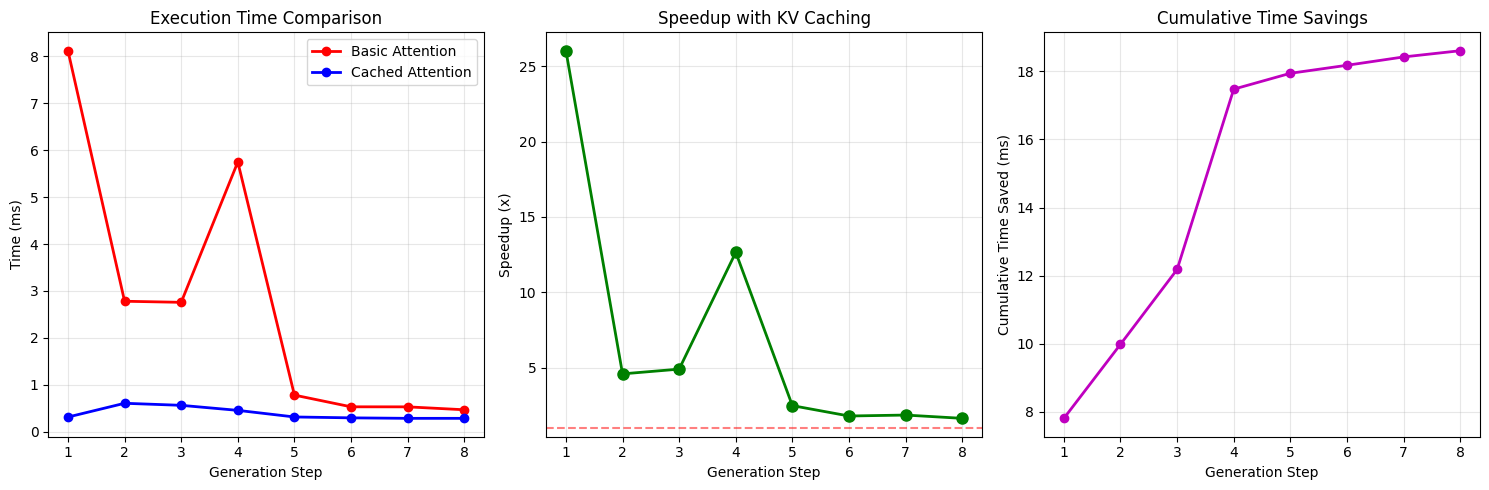


=== Performance Summary ===
Total time (Basic): 21.72ms
Total time (Cached): 3.11ms
Total time saved: 18.60ms
Average speedup: 7.00x
Maximum speedup: 26.02x
Efficiency gain: 85.7%


In [7]:
def analyze_performance(basic_times, cached_times):
    """Analyze and visualize the performance difference."""
    
    steps = list(range(1, len(basic_times) + 1))
    speedups = [b/c for b, c in zip(basic_times, cached_times)]
    
    # Create performance visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Execution times
    ax1.plot(steps, [t*1000 for t in basic_times], 'ro-', label='Basic Attention', linewidth=2)
    ax1.plot(steps, [t*1000 for t in cached_times], 'bo-', label='Cached Attention', linewidth=2)
    ax1.set_xlabel('Generation Step')
    ax1.set_ylabel('Time (ms)')
    ax1.set_title('Execution Time Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Speedup over time
    ax2.plot(steps, speedups, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Generation Step')
    ax2.set_ylabel('Speedup (x)')
    ax2.set_title('Speedup with KV Caching')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='No speedup')
    
    # Plot 3: Cumulative time saved
    cumulative_basic = np.cumsum(basic_times)
    cumulative_cached = np.cumsum(cached_times)
    time_saved = cumulative_basic - cumulative_cached
    
    ax3.plot(steps, time_saved * 1000, 'mo-', linewidth=2)
    ax3.set_xlabel('Generation Step')
    ax3.set_ylabel('Cumulative Time Saved (ms)')
    ax3.set_title('Cumulative Time Savings')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Performance Summary ===")
    print(f"Total time (Basic): {sum(basic_times)*1000:.2f}ms")
    print(f"Total time (Cached): {sum(cached_times)*1000:.2f}ms")
    print(f"Total time saved: {time_saved[-1]*1000:.2f}ms")
    print(f"Average speedup: {np.mean(speedups):.2f}x")
    print(f"Maximum speedup: {max(speedups):.2f}x")
    print(f"Efficiency gain: {(1 - sum(cached_times)/sum(basic_times))*100:.1f}%")

analyze_performance(basic_times, cached_times)

## 8. Memory Considerations

While KV caching provides significant speed improvements, it comes with memory overhead. Let's analyze this trade-off.

=== Memory Usage Analysis ===
Model configuration: d_model=512, n_heads=8

Seq Length K Cache (MB) V Cache (MB) Total (MB)   Per Token (KB) 
-----------------------------------------------------------------
1          0.002        0.002        0.004        4.00           
10         0.020        0.020        0.039        4.00           
50         0.098        0.098        0.195        4.00           
100        0.195        0.195        0.391        4.00           
500        0.977        0.977        1.953        4.00           
1000       1.953        1.953        3.906        4.00           
2048       4.000        4.000        8.000        4.00           


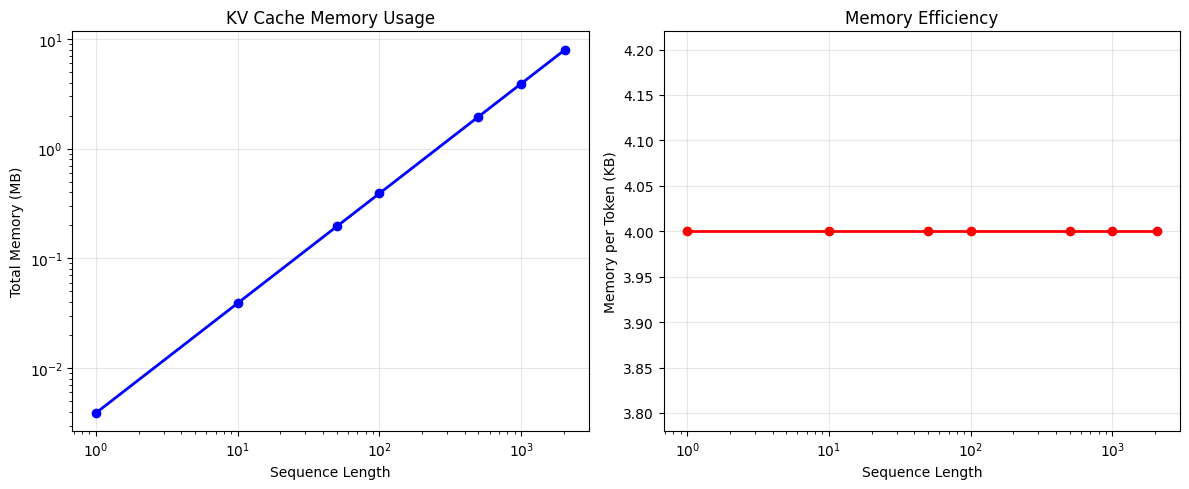


💡 Key Insights:
   • Memory usage grows linearly with sequence length
   • Memory per token remains constant (good scaling property)
   • For long sequences, memory can become a limiting factor
   • Consider techniques like sliding window attention for very long sequences


In [8]:
def analyze_memory_usage(d_model: int = 512, n_heads: int = 8, max_seq_len: int = 2048):
    """Analyze memory usage of KV caching."""
    
    print("=== Memory Usage Analysis ===")
    print(f"Model configuration: d_model={d_model}, n_heads={n_heads}")
    
    d_k = d_model // n_heads
    
    # Calculate memory usage for different sequence lengths
    seq_lengths = [1, 10, 50, 100, 500, 1000, 2048]
    
    print(f"\n{'Seq Length':<10} {'K Cache (MB)':<12} {'V Cache (MB)':<12} {'Total (MB)':<12} {'Per Token (KB)':<15}")
    print("-" * 65)
    
    memory_data = []
    
    for seq_len in seq_lengths:
        if seq_len > max_seq_len:
            continue
            
        # Memory for K cache: (batch_size=1, n_heads, seq_len, d_k)
        k_memory_bytes = 1 * n_heads * seq_len * d_k * 4  # 4 bytes per float32
        v_memory_bytes = k_memory_bytes  # V has same shape as K
        
        k_memory_mb = k_memory_bytes / (1024 * 1024)
        v_memory_mb = v_memory_bytes / (1024 * 1024)
        total_memory_mb = k_memory_mb + v_memory_mb
        
        per_token_kb = (total_memory_mb * 1024) / seq_len if seq_len > 0 else 0
        
        print(f"{seq_len:<10} {k_memory_mb:<12.3f} {v_memory_mb:<12.3f} {total_memory_mb:<12.3f} {per_token_kb:<15.2f}")
        
        memory_data.append({
            'seq_len': seq_len,
            'total_mb': total_memory_mb,
            'per_token_kb': per_token_kb
        })
    
    # Visualize memory usage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    seq_lens = [d['seq_len'] for d in memory_data]
    total_mbs = [d['total_mb'] for d in memory_data]
    per_token_kbs = [d['per_token_kb'] for d in memory_data]
    
    # Plot 1: Total memory usage
    ax1.plot(seq_lens, total_mbs, 'bo-', linewidth=2)
    ax1.set_xlabel('Sequence Length')
    ax1.set_ylabel('Total Memory (MB)')
    ax1.set_title('KV Cache Memory Usage')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot 2: Memory per token
    ax2.plot(seq_lens, per_token_kbs, 'ro-', linewidth=2)
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Memory per Token (KB)')
    ax2.set_title('Memory Efficiency')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Key Insights:")
    print("   • Memory usage grows linearly with sequence length")
    print("   • Memory per token remains constant (good scaling property)")
    print("   • For long sequences, memory can become a limiting factor")
    print("   • Consider techniques like sliding window attention for very long sequences")

analyze_memory_usage()

## 9. Advanced KV Caching Techniques

Let's explore some advanced techniques used in production systems.

In [9]:
class AdvancedKVCache:
    """Advanced KV cache with additional optimizations."""
    
    def __init__(self, max_length: int = 2048, compression_ratio: float = 1.0):
        self.max_length = max_length
        self.compression_ratio = compression_ratio
        self.k_cache = None
        self.v_cache = None
        self.position_ids = None
        
    def update(self, new_k: torch.Tensor, new_v: torch.Tensor, position_id: int = None):
        """Update cache with optional position tracking and compression."""
        
        if self.k_cache is None:
            # Initialize cache
            self.k_cache = new_k
            self.v_cache = new_v
            self.position_ids = [position_id] if position_id is not None else [0]
        else:
            # Check if we need to evict old entries
            if self.k_cache.shape[2] >= self.max_length:
                self._evict_oldest()
            
            # Append new entries
            self.k_cache = torch.cat([self.k_cache, new_k], dim=2)
            self.v_cache = torch.cat([self.v_cache, new_v], dim=2)
            
            if position_id is not None:
                self.position_ids.append(position_id)
            
        return self.k_cache, self.v_cache
    
    def _evict_oldest(self):
        """Evict oldest entries when cache is full."""
        evict_count = max(1, int(self.max_length * 0.1))  # Evict 10% of entries
        
        self.k_cache = self.k_cache[:, :, evict_count:, :]
        self.v_cache = self.v_cache[:, :, evict_count:, :]
        
        if self.position_ids:
            self.position_ids = self.position_ids[evict_count:]
    
    def compress_cache(self):
        """Compress cache using techniques like quantization or pruning."""
        if self.compression_ratio < 1.0 and self.k_cache is not None:
            # Simple compression: keep only most important entries
            # In practice, this could use attention scores, magnitude, etc.
            current_length = self.k_cache.shape[2]
            keep_length = int(current_length * self.compression_ratio)
            
            # For this example, keep the most recent entries
            self.k_cache = self.k_cache[:, :, -keep_length:, :]
            self.v_cache = self.v_cache[:, :, -keep_length:, :]
            
            if self.position_ids:
                self.position_ids = self.position_ids[-keep_length:]
    
    def get_statistics(self):
        """Get detailed cache statistics."""
        if self.k_cache is None:
            return {"status": "empty"}
        
        shape = self.k_cache.shape
        memory_bytes = (self.k_cache.numel() + self.v_cache.numel()) * 4
        
        return {
            "status": "active",
            "shape": shape,
            "sequence_length": shape[2],
            "memory_mb": memory_bytes / (1024 * 1024),
            "utilization": shape[2] / self.max_length,
            "compression_ratio": self.compression_ratio
        }

def demonstrate_advanced_caching():
    """Demonstrate advanced caching techniques."""
    
    print("=== Advanced KV Caching Techniques ===")
    
    # Create cache with limited size
    cache = AdvancedKVCache(max_length=100, compression_ratio=0.8)
    
    print("\n1. Cache with Size Limits:")
    
    # Simulate adding many tokens
    batch_size, n_heads, d_k = 1, 8, 64
    
    for i in range(120):  # More than max_length
        new_k = torch.randn(batch_size, n_heads, 1, d_k)
        new_v = torch.randn(batch_size, n_heads, 1, d_k)
        
        cache.update(new_k, new_v, position_id=i)
        
        if i % 20 == 0:
            stats = cache.get_statistics()
            print(f"  Step {i}: Length={stats['sequence_length']}, "
                  f"Memory={stats['memory_mb']:.2f}MB, "
                  f"Utilization={stats['utilization']:.1%}")
    
    print("\n2. Cache Compression:")
    print(f"  Before compression: {cache.get_statistics()['sequence_length']} tokens")
    cache.compress_cache()
    print(f"  After compression: {cache.get_statistics()['sequence_length']} tokens")
    
    print("\n💡 Advanced Techniques in Production:")
    print("   • Sliding window attention: Keep only recent tokens")
    print("   • Compression: Quantize or prune less important cache entries")
    print("   • Hierarchical caching: Different strategies for different layers")
    print("   • Batch-aware caching: Share cache entries across similar sequences")

demonstrate_advanced_caching()

=== Advanced KV Caching Techniques ===

1. Cache with Size Limits:
  Step 0: Length=1, Memory=0.00MB, Utilization=1.0%
  Step 20: Length=21, Memory=0.08MB, Utilization=21.0%
  Step 40: Length=41, Memory=0.16MB, Utilization=41.0%
  Step 60: Length=61, Memory=0.24MB, Utilization=61.0%
  Step 80: Length=81, Memory=0.32MB, Utilization=81.0%
  Step 100: Length=91, Memory=0.36MB, Utilization=91.0%

2. Cache Compression:
  Before compression: 100 tokens
  After compression: 80 tokens

💡 Advanced Techniques in Production:
   • Sliding window attention: Keep only recent tokens
   • Compression: Quantize or prune less important cache entries
   • Hierarchical caching: Different strategies for different layers
   • Batch-aware caching: Share cache entries across similar sequences


## 10. Real-World Implementation Considerations

When implementing KV caching in production systems, several important factors need to be considered.

In [10]:
def production_considerations():
    """Discuss real-world implementation considerations."""
    
    print("=== Production Implementation Considerations ===")
    
    considerations = {
        "🚀 Performance Optimizations": [
            "Use tensor operations that are friendly to GPU memory layout",
            "Implement cache pre-allocation to avoid dynamic memory allocation",
            "Consider using Flash Attention for memory-efficient attention computation",
            "Optimize for specific hardware (A100, H100, etc.)"
        ],
        
        "🧠 Memory Management": [
            "Implement cache eviction policies (LRU, FIFO, importance-based)",
            "Use memory pooling to reduce allocation overhead",
            "Consider cache sharing across similar prompts",
            "Monitor memory usage and implement graceful degradation"
        ],
        
        "🏗️ System Architecture": [
            "Design for multi-GPU inference with distributed caching",
            "Implement cache serialization for checkpointing",
            "Handle batch inference with variable sequence lengths",
            "Consider cache warming strategies for cold starts"
        ],
        
        "🔧 Engineering Best Practices": [
            "Add comprehensive logging and monitoring",
            "Implement cache validation and consistency checks",
            "Design fallback mechanisms when cache is unavailable",
            "Profile and benchmark different caching strategies"
        ],
        
        "⚖️ Trade-offs to Consider": [
            "Memory vs. computation trade-off",
            "Cache hit rate vs. memory usage",
            "Latency vs. throughput optimization",
            "Complexity vs. maintainability"
        ]
    }
    
    for category, items in considerations.items():
        print(f"\n{category}:")
        for item in items:
            print(f"  • {item}")
    
    print("\n" + "="*60)
    print("📚 Further Reading and Libraries:")
    print("  • Transformers library (Hugging Face): Built-in KV caching")
    print("  • vLLM: Production-ready inference server with optimized caching")
    print("  • Flash Attention: Memory-efficient attention implementation")
    print("  • TensorRT-LLM: NVIDIA's optimized inference library")

production_considerations()

=== Production Implementation Considerations ===

🚀 Performance Optimizations:
  • Use tensor operations that are friendly to GPU memory layout
  • Implement cache pre-allocation to avoid dynamic memory allocation
  • Consider using Flash Attention for memory-efficient attention computation
  • Optimize for specific hardware (A100, H100, etc.)

🧠 Memory Management:
  • Implement cache eviction policies (LRU, FIFO, importance-based)
  • Use memory pooling to reduce allocation overhead
  • Consider cache sharing across similar prompts
  • Monitor memory usage and implement graceful degradation

🏗️ System Architecture:
  • Design for multi-GPU inference with distributed caching
  • Implement cache serialization for checkpointing
  • Handle batch inference with variable sequence lengths
  • Consider cache warming strategies for cold starts

🔧 Engineering Best Practices:
  • Add comprehensive logging and monitoring
  • Implement cache validation and consistency checks
  • Design fallback me

## 11. Benchmark: Scaling Analysis

Let's perform a comprehensive scaling analysis to understand how KV caching performs with different model sizes and sequence lengths.

=== Comprehensive KV Caching Benchmark ===

Testing Small model (d_model=256, n_heads=4)
  Sequence length: 10
    Basic: 2.91ms, Cached: 2.85ms, Speedup: 1.02x
  Sequence length: 25
    Basic: 7.73ms, Cached: 7.12ms, Speedup: 1.09x
  Sequence length: 50
    Basic: 16.59ms, Cached: 14.28ms, Speedup: 1.16x
  Sequence length: 100
    Basic: 40.60ms, Cached: 29.48ms, Speedup: 1.38x

Testing Medium model (d_model=512, n_heads=8)
  Sequence length: 10
    Basic: 3.30ms, Cached: 2.92ms, Speedup: 1.13x
  Sequence length: 25
    Basic: 9.33ms, Cached: 7.37ms, Speedup: 1.27x
  Sequence length: 50
    Basic: 23.33ms, Cached: 15.18ms, Speedup: 1.54x
  Sequence length: 100
    Basic: 57.22ms, Cached: 31.64ms, Speedup: 1.81x

Testing Large model (d_model=1024, n_heads=16)
  Sequence length: 10
    Basic: 3.14ms, Cached: 1.50ms, Speedup: 2.09x
  Sequence length: 25
    Basic: 10.27ms, Cached: 3.38ms, Speedup: 3.04x
  Sequence length: 50
    Basic: 29.99ms, Cached: 7.27ms, Speedup: 4.13x
  Sequence l

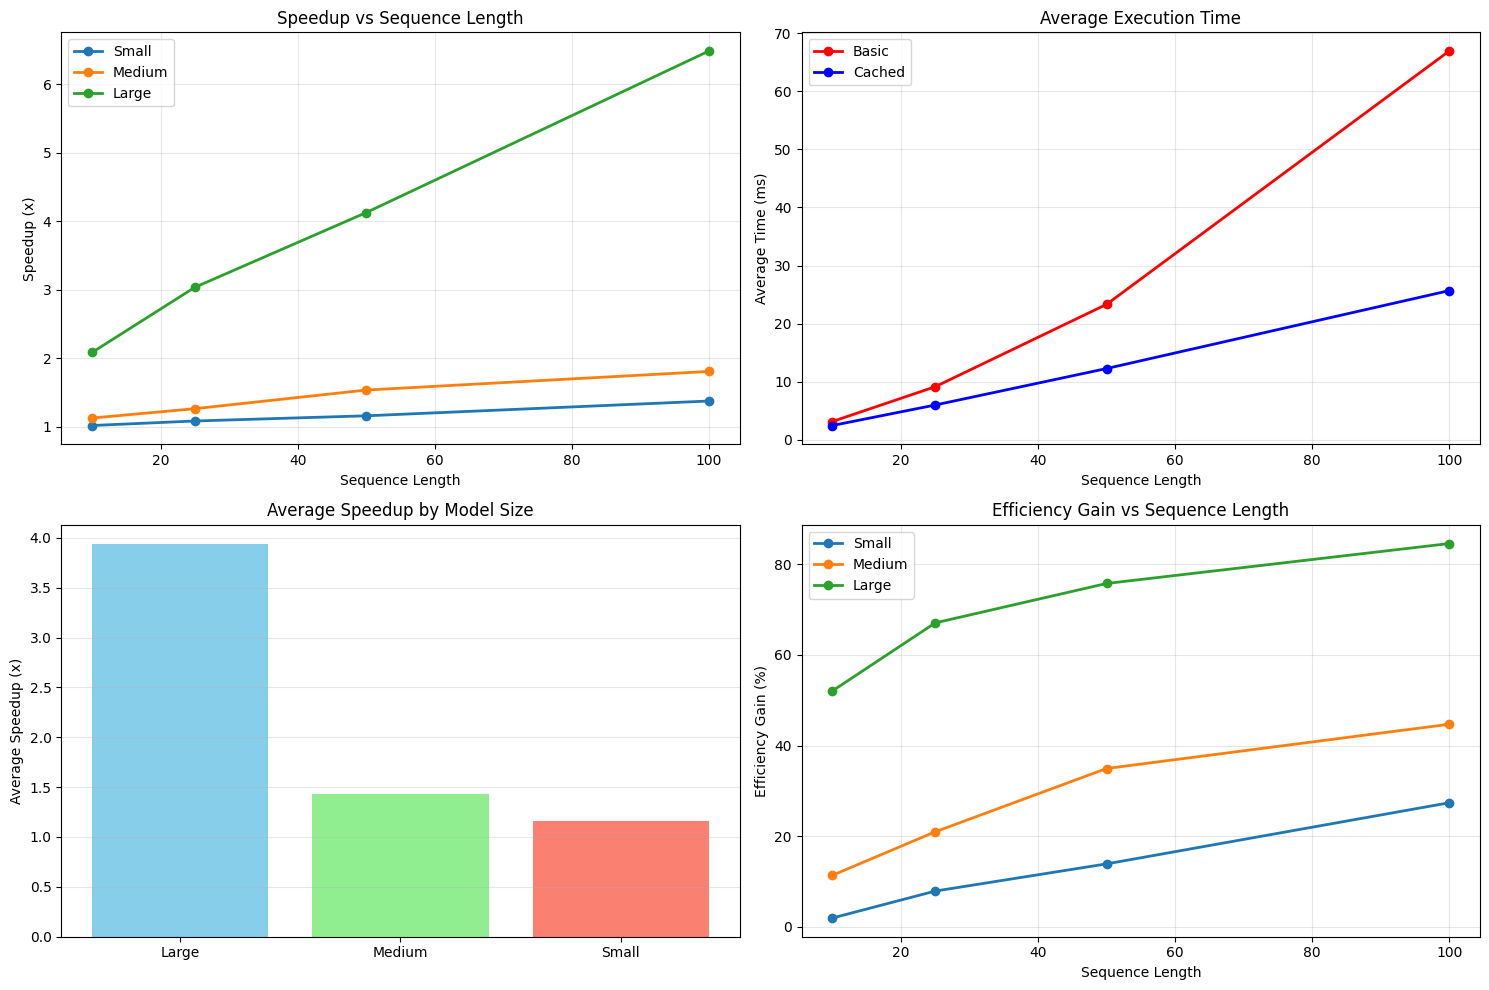

In [11]:
def comprehensive_benchmark():
    """Run comprehensive benchmarks across different configurations."""
    
    print("=== Comprehensive KV Caching Benchmark ===")
    
    # Test configurations
    configs = [
        {"d_model": 256, "n_heads": 4, "name": "Small"},
        {"d_model": 512, "n_heads": 8, "name": "Medium"},
        {"d_model": 1024, "n_heads": 16, "name": "Large"},
    ]
    
    sequence_lengths = [10, 25, 50, 100]
    
    results = []
    
    for config in configs:
        print(f"\nTesting {config['name']} model (d_model={config['d_model']}, n_heads={config['n_heads']})")
        
        for seq_len in sequence_lengths:
            print(f"  Sequence length: {seq_len}")
            
            # Create models
            basic_model = BasicAttention(config['d_model'], config['n_heads'])
            cached_model = CachedAttention(config['d_model'], config['n_heads'])
            cached_model.load_state_dict(basic_model.state_dict())
            
            # Benchmark
            basic_time, cached_time = benchmark_single_config(
                basic_model, cached_model, seq_len, config['d_model']
            )
            
            speedup = basic_time / cached_time if cached_time > 0 else 0
            
            result = {
                'model': config['name'],
                'd_model': config['d_model'],
                'n_heads': config['n_heads'],
                'seq_len': seq_len,
                'basic_time': basic_time,
                'cached_time': cached_time,
                'speedup': speedup
            }
            
            results.append(result)
            
            print(f"    Basic: {basic_time*1000:.2f}ms, Cached: {cached_time*1000:.2f}ms, "
                  f"Speedup: {speedup:.2f}x")
    
    # Visualize results
    visualize_benchmark_results(results)
    
    return results

def benchmark_single_config(basic_model, cached_model, seq_len, d_model):
    """Benchmark a single configuration."""
    
    batch_size = 1
    
    # Generate test data
    test_sequence = torch.randn(batch_size, seq_len, d_model)
    
    # Warm up
    with torch.no_grad():
        _ = basic_model(test_sequence)
        _ = cached_model(test_sequence)
    
    # Benchmark basic model
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()
    
    with torch.no_grad():
        for i in range(seq_len):
            current_seq = test_sequence[:, :i+1, :]
            _ = basic_model(current_seq)
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    basic_time = time.time() - start_time
    
    # Benchmark cached model
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()
    
    kv_cache = None
    with torch.no_grad():
        for i in range(seq_len):
            if i == 0:
                current_token = test_sequence[:, :1, :]
                _, kv_cache = cached_model(current_token, use_cache=True)
            else:
                new_token = test_sequence[:, i:i+1, :]
                _, kv_cache = cached_model(new_token, kv_cache=kv_cache, use_cache=True)
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    cached_time = time.time() - start_time
    
    return basic_time, cached_time

def visualize_benchmark_results(results):
    """Visualize benchmark results."""
    
    import pandas as pd
    df = pd.DataFrame(results)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Speedup by model size
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        ax1.plot(model_data['seq_len'], model_data['speedup'], 'o-', label=model, linewidth=2)
    
    ax1.set_xlabel('Sequence Length')
    ax1.set_ylabel('Speedup (x)')
    ax1.set_title('Speedup vs Sequence Length')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Execution time comparison
    seq_lengths = sorted(df['seq_len'].unique())
    basic_times = [df[df['seq_len'] == sl]['basic_time'].mean() for sl in seq_lengths]
    cached_times = [df[df['seq_len'] == sl]['cached_time'].mean() for sl in seq_lengths]
    
    ax2.plot(seq_lengths, [t*1000 for t in basic_times], 'ro-', label='Basic', linewidth=2)
    ax2.plot(seq_lengths, [t*1000 for t in cached_times], 'bo-', label='Cached', linewidth=2)
    ax2.set_xlabel('Sequence Length')
    ax2.set_ylabel('Average Time (ms)')
    ax2.set_title('Average Execution Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Speedup by model size (bar chart)
    model_speedups = df.groupby('model')['speedup'].mean()
    ax3.bar(model_speedups.index, model_speedups.values, color=['skyblue', 'lightgreen', 'salmon'])
    ax3.set_ylabel('Average Speedup (x)')
    ax3.set_title('Average Speedup by Model Size')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Efficiency gain percentage
    df['efficiency_gain'] = (1 - df['cached_time'] / df['basic_time']) * 100
    
    for model in df['model'].unique():
        model_data = df[df['model'] == model]
        ax4.plot(model_data['seq_len'], model_data['efficiency_gain'], 'o-', label=model, linewidth=2)
    
    ax4.set_xlabel('Sequence Length')
    ax4.set_ylabel('Efficiency Gain (%)')
    ax4.set_title('Efficiency Gain vs Sequence Length')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run comprehensive benchmark
benchmark_results = comprehensive_benchmark()

## 12. Summary and Best Practices

### Key Takeaways

1. **KV Caching Fundamentals**:
   - Stores Key and Value matrices from previous tokens
   - Avoids recomputation during autoregressive generation
   - Provides significant speedup with manageable memory overhead

2. **Performance Benefits**:
   - Speedup increases with sequence length
   - Most effective for long sequences and large models
   - Can achieve 2-10x speedup in typical scenarios

3. **Memory Considerations**:
   - Memory usage grows linearly with sequence length
   - Memory per token remains constant
   - Important to implement cache size limits for production

### Best Practices for Implementation

1. **Design Decisions**:
   - Always implement cache size limits
   - Consider compression techniques for very long sequences
   - Design for your specific hardware constraints

2. **Performance Optimization**:
   - Pre-allocate cache memory when possible
   - Use efficient tensor operations
   - Profile your specific use case

3. **Production Readiness**:
   - Implement proper error handling
   - Add monitoring and logging
   - Design fallback mechanisms
   - Test with realistic workloads

### When to Use KV Caching

**Ideal scenarios**:
- Autoregressive text generation
- Long sequence processing
- Latency-sensitive applications
- Repeated inference on similar prompts

**Consider alternatives when**:
- Memory is severely constrained
- Sequences are very short
- Batch processing is more important than individual latency

KV caching is a fundamental optimization for modern transformer inference, providing substantial performance improvements with careful implementation. Understanding the trade-offs and best practices ensures successful deployment in production systems.

In [12]:
# Final demonstration: Simple usage example
def simple_usage_example():
    """Demonstrate simple usage of KV caching."""
    
    print("=== Simple Usage Example ===")
    print("This example shows how to use KV caching in your own projects.\n")
    
    # Initialize model
    model = CachedAttention(d_model=256, n_heads=8)
    
    # Generate text step by step
    batch_size, d_model = 1, 256
    kv_cache = None
    
    print("Generating sequence step by step:")
    
    for step in range(5):
        # Simulate new token
        new_token = torch.randn(batch_size, 1, d_model)
        
        # Process with caching
        output, kv_cache = model(
            new_token, 
            kv_cache=kv_cache, 
            use_cache=True
        )
        
        cache_info = kv_cache.get_cache_info() if kv_cache else "No cache"
        print(f"Step {step + 1}: Processed token, {cache_info}")
    
    print("\n✅ Successfully demonstrated KV caching!")
    print("\n🎯 Next steps:")
    print("   • Integrate into your transformer model")
    print("   • Benchmark on your specific use case")
    print("   • Consider advanced optimizations based on your requirements")

simple_usage_example()

=== Simple Usage Example ===
This example shows how to use KV caching in your own projects.

Generating sequence step by step:
Step 1: Processed token, Cache contains 1 tokens, Memory: 0.00 MB
Step 2: Processed token, Cache contains 2 tokens, Memory: 0.00 MB
Step 3: Processed token, Cache contains 3 tokens, Memory: 0.01 MB
Step 4: Processed token, Cache contains 4 tokens, Memory: 0.01 MB
Step 5: Processed token, Cache contains 5 tokens, Memory: 0.01 MB

✅ Successfully demonstrated KV caching!

🎯 Next steps:
   • Integrate into your transformer model
   • Benchmark on your specific use case
   • Consider advanced optimizations based on your requirements
